#### **Agenda**
In This Lecture, We Will Cover:
- A brief introduction to Computer Vision field.
- Why Vanilla NN is **NOT** suited for Image Data? Explained with a real-world example!
- Taking motivations for a new architecture from **Human Visual Cortex System**.
- Defining the new architecture, aka **CNNs** and its components!

Helpful Link: https://poloclub.github.io/cnn-explainer/#article-convolution


####Q. **What is Computer Vision (CV)?**



These problems might be easy for humans as we are trained with many years of image data, but What about Computers?

Before even answering this question, let's investigate - <br>
###**What a Computer actually sees?**<br>
- A **Digital Image** is a matrix of size (H,W,C), comprising of numbers (also known as pixel values) typically ranging from 0-255. Here H,W,C denote Height, Width and No. of Channels in a image.
- For a Grayscale image, # channels is 1, while for Colored Image its 3.


####Q. **Why Deep Neural Network for Images?**

In order to understand why DNN works, we need to account for how visual cortex functions!

Our Visual Cortex system is arranged in layers and as information passes from the eyes to deeper parts of the brain, higher and higher order representations are formed. Since a DNN also works in a similar way, using it for analyzing Images makes perfect sense.


<img src='https://drive.google.com/uc?id=1IkIqSSDHlSLeVDHdu1n-ZsHbiqMs5nAe' height=550>

####**But what about the architecture of DNN, will Vanilla NN or MLP be a suitable fit?**

### We will answer this question in Part 1 of the module!

# PART 1: Hammer and Screw


In the Previous lectures we learnt about ANNs and where to use them.   

Now let's experiment what happens if we try to fit a Vanilla Neural Network (Hammer) to a very different kind of data, aka Images (Screw) and why this hammering of screw doesn't make sense!


- Amazon wants to develop an automated system to categorize a clothing product into its master category
    - Link of website to show demo :(https://www.amazon.in/b/?_encoding=UTF8&node=7459780031&ref_=sv_top_ap_mega_1)
- You are given the job to classify clothes into 10 different classes
- Since it's a multi-class classification problem on a labelled dataset and you have just studied about ANN, you feel encouraged to apply it to this scenario.
- You try to implement a ANN but somehow, it gives very poor results
- So why didn't the ANN work..? and what else would ?

Let's find out -

# Part 1: (Hammering the Screw)  
  
  Scenario:  **Classify the fashion image into one of the 10 categories**  
  Inventory: Vanilla NN (hammer) and CNN (new tool)


## 0. Setup

As always, we will start by downloading resources, installing packages and importing them to the environment!   
- 0.1 Download Resources  
- 0.2 Import Libraries  

### 0.1 Download Data

We are going to use a collection of real-world clothing images dataset, opensourced [here](https://github.com/alexeygrigorev/clothing-dataset-small).  

You can read more about the dataset in this [blog post](https://medium.com/data-science-insider/clothing-dataset-5b72cd7c3f1f).

In [3]:
#!unzip /content/clothing-dataset-small.zip
#!unzip clothing-dataset-small.zip

# check if unzipped files exist, if not, unzip again
import os
if not os.path.exists("clothing-dataset-small"):
	print("Unzipping files...")
	# Unzip the dataset
	!unzip clothing-dataset-small.zip
else:
	print("Files already unzipped.")

Files already unzipped.


In [4]:
# Import common libraries
import os
import glob
import random
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import tensorflow and its modules
import tensorflow as tf
from tensorflow import keras # this allows <keras.> instead of <tf.keras.>
from tensorflow.keras import layers # this allows <layers.> instead of <tf.keras.layers.>
tf.keras.utils.set_random_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [6]:
class_dirs = os.listdir("clothing-dataset-small/train") # list all directories inside "train" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'clothing-dataset-small/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

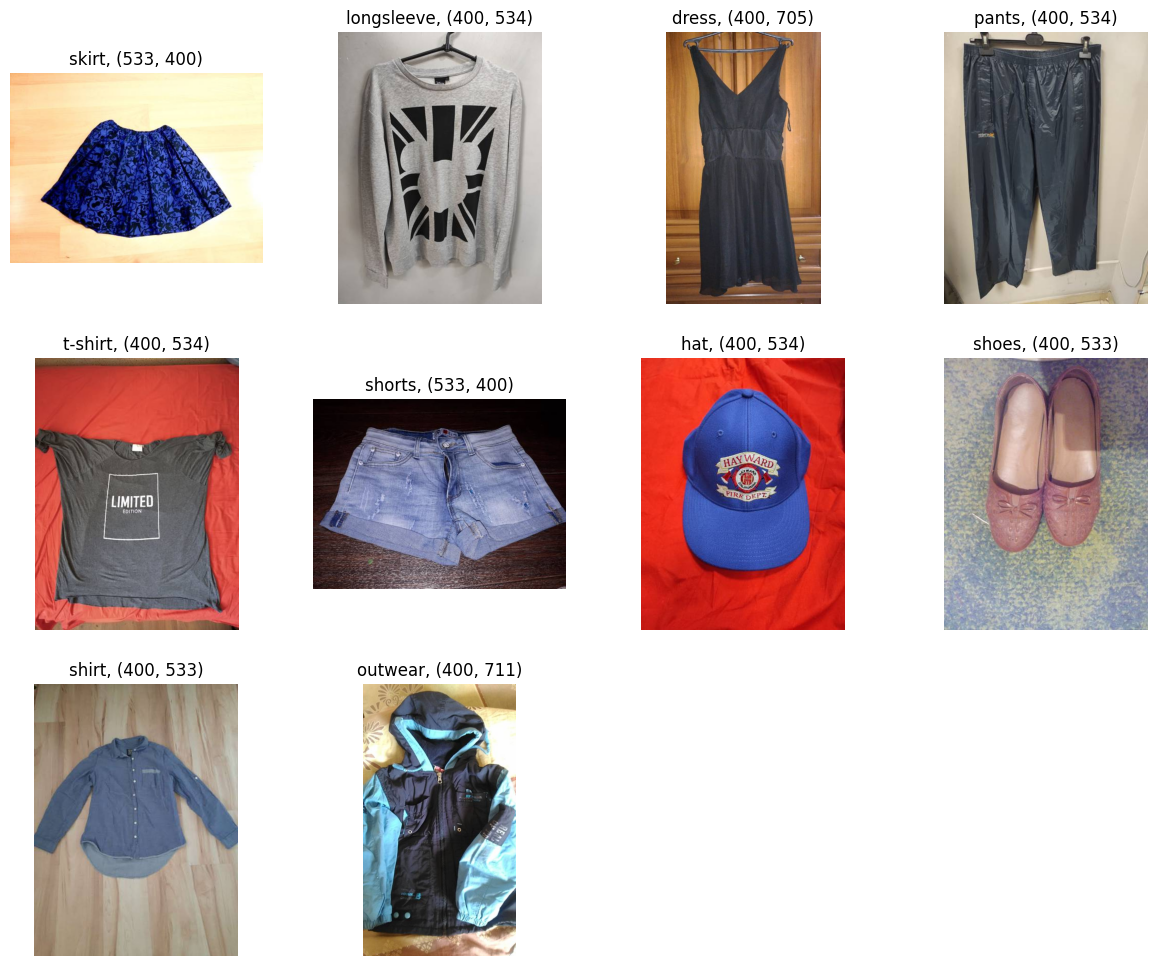

In [7]:
## Viz Random Sample from each class

plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

- Notice that every Image has **different dimension!**
- This is expected in a real-world data, but can you guess why this is **not ideal**? Hint: Batching requires all samples to be of the same size!
- We will see later how we can handle this issue!

Count of training samples per class:
         class  count
0       skirt    112
1  longsleeve    455
2       dress    241
3       pants    468
4     t-shirt    795
5      shorts    202
6         hat    123
7       shoes    198
8       shirt    290
9     outwear    184


<Axes: title={'center': 'Training Data Count per class'}, xlabel='class'>

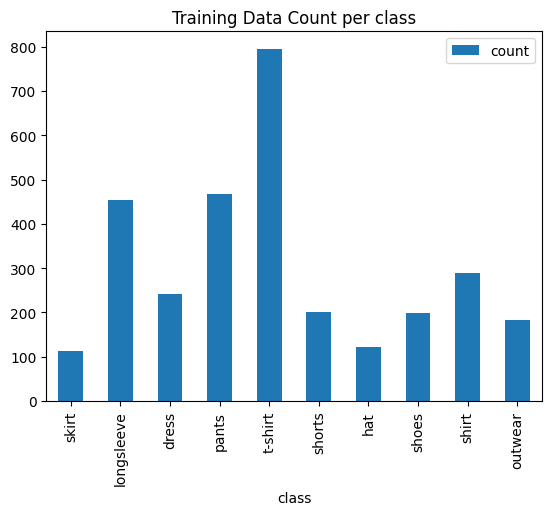

In [8]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")

- Note that the `train/val/test` split already provided, we needn't create it explicitly!
- Also, we can observe that the data is **imbalanced**. For this lecture, we will work with the given data-distribution, but later on we will see some common techniques to work with imbalanced-data! (Any thoughts?)

## 2. Preprocessing

### Q. **What type of Preprocessing is required here?**  
  
- 2.1 Shape Preprocessing  
- 2.2 Value Preprocessing   
- 2.3 Additional Shape Preprocessing for MLPs

#### Before that, lets ***mount*** the data directory in Keras using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function

Keras provides a utility function (`tf.keras.utils.image_dataset_from_directory`) to directly load data from directory in `tf.data.Dataset` format.

In [9]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/test", shuffle = False,
)


Loading Train Data...
Found 3068 files belonging to 10 classes.

Loading Validation Data...
Found 341 files belonging to 10 classes.

Loading Test Data...
Found 372 files belonging to 10 classes.


2025-06-22 15:13:42.207844: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-06-22 15:13:42.207885: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2025-06-22 15:13:42.207888: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
I0000 00:00:1750585422.207899  769127 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750585422.207922  769127 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 2.1 Shape Preprocessing (Resizing)

- The dataset may contain images of different sizes, but a batch in keras, requires all of them to be of the same size. (Why? , How?)
- This can be achieved in a multiple of ways, but the most common technique is to resize all images to a fixed size (128,128)   

*Note: We can also provide the resizing parameters while loading data itself.*

### 2.2 Value Preprocessing (Rescaling)

- We also convert the datatype of input tensor from `uint8` to `float32` and rescale the values to lie between 0 and 1 instead of 0 and 255. (Why?)
- Without scaling, the high pixel range images will have large influence on loss values and thereby weight updation. (Eg: Black cat vs White cat)

### 2.3 Shape Preprocessing for MLPs (Flatten)

- Images are 2D* objects (with channel acting as an additional dimension)
- But Neural Networks requires each sample to be 1D or flat!
- Now Flattening of this matrix will lead to 3 elements of the vector to have value for that particular pixel as shown below.


><img src='https://drive.google.com/uc?id=1LXJfVbDG23ro2t-7jZ1FC_kzXBT4Xfpw' height=600>

- We will be using **Keras API** `Flatten layer` to convert the image matrix into vector
- It will change `bs x 256 x 256 x 3` to `bs x 196608`

In [10]:
height, width = 128, 128 # Optional, not required if we already have resized the data from `image_dataset_from_directory` function.

# Data Processing Stage with resizing and rescaling operations
data_preprocess_with_flatten = keras.Sequential(
    name = "data_preprocess_with_flatten",
    layers = [
        layers.Resizing(height, width),
        layers.Rescaling(1./255),
        layers.Flatten(), # Note: We prefer NOT to add `layers.Flatten()` as part of preprocessing layers (rather as model definition itself)!
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess_with_flatten(x), y))


Let's visualize a sample after preprocessing:

In [11]:
sample = next(iter(train_ds))[0]

print(sample)

tf.Tensor(
[[0.09552696 0.08768383 0.09944853 ... 0.5103711  0.47507697 0.4084103 ]
 [0.19276579 0.04910769 0.06562117 ... 0.4493935  0.12782486 0.18272682]
 [0.63098645 0.5407904  0.6113786  ... 0.93143386 0.939277   0.9353554 ]
 ...
 [0.49344397 0.49344397 0.46207142 ... 0.19694066 0.19694066 0.1655681 ]
 [0.54509807 0.43921572 0.2627451  ... 0.81038606 0.73587626 0.5672488 ]
 [0.15490197 0.04509804 0.10000001 ... 0.2515235  0.07401124 0.13448918]], shape=(32, 49152), dtype=float32)


- Its preferred to use flatten layer as part of **model definition**, instead of preprocessing stack, since it's a non-standard preprocessing step, which is not required while working with CNNs.

In [12]:
# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

# **Quiz 1.** A ___ is a preprocessing layer which rescales input values to a new range.<br>
a) Batch Normalization<br>
b) Residual Layer<br>
c) Rescaling<br>
d) Flatten<br>
<br>

Ans : c)
Before feeding into a neural network, we often rescale the values of image pixels to lie between 0 and 1.<br>
This layer rescales every value of an input (often an image) by multiplying by scale and adding offset.


## 3. Training Neural Network

We will start by training a Vanilla NN and then check its performance on test dataset, after this we will switch to CNNs and see how much performance improvement we can get out of it!

- 3.1 Model Architecture of Vanilla NN
- 3.2 Loss function and Optimizer  
- 3.3 Training and Evaluation with Vanilla NN   
- 3.4 Replacing Vanilla NN with CNNs  
- 3.5 Training and Evaluation with CNNs

### 3.1 Model Architecture of Vanilla NN

- Recall the Neural Network structure covered in earilier lecture,
  
- How Neural Network is made of an Input layer, few Hidden layers and an Output layer with each neuron training on a distinct set of features based on the previous layer’s output.
  
- These complex connection (weight matrix W) between the neurons helps NN to recognize patterns in the data
><img src='https://drive.google.com/uc?id=19BIzu4JiXHNqBgTNXc8PMk_qaYR2nFK5' height=350>


In [13]:
num_classes = 10
hidden_size_1 = 1024
hidden_size_2 = 256

model = keras.Sequential(
    name="model_ann",
    layers=[
        layers.Flatten(input_shape=(height, width, 3)), # alternatively, input_shape=next(iter(train_ds))[0].shape[1:]
        layers.Dense(units=hidden_size_1, activation='relu'), # hidden layer 1
        layers.Dense(units=hidden_size_2, activation='relu'), # hidden layer 2
        layers.Dense(units=num_classes, activation='softmax'), # output layer
    ]
)

- So now that we have created the model,  
Lets Visualize **the structure of the model and the number of parameters,** using `.summary()` method.

In [14]:
model.summary()

Model: "model_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,597,642 (193.01 MB)

 Trainable params: 50,597,642 (193.01 MB)

 Non-trainable params: 0 (0.00 B)

- Lets also **plot the model structure** in the form os a graph using `tf.keras.utils.plot_model` command!

In [15]:
tf.keras.utils.plot_model(model, to_file="model_ann.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### **Q. We have loaded data and defined model architecture, is there something else we need to do, before we start training?**  

We need loss functions and optimizers!

### 3.2 Loss Function and Optimizer

a. Which loss function to use for multi-class classification?

- **Cross-Entropy loss function might work**

Lets take an example:
- Supposedly we have a **4 class image classification task of whether the object in the image belong to Dog, Cat, Horse or Cheetah**

- And we train a NN layer

<center>  <img src='https://drive.google.com/uc?id=1CCx2lgwGW2mTIZvbmi85NN1UpjlxRgXX' height=250></center>


- Notice how **Softmax converts logits (Ouput values) into probabilities.**
- The purpose of the **Cross-Entropy is to take these output probabilities (P) and measure the distance** from the truth values

<center>  <img src='https://drive.google.com/uc?id=1yAJ_jb7yCUlnsvQ_eHxc1nKPPcCAdxlj' height=250></center>
<center>  <img src='https://drive.google.com/uc?
id=1mCOeR0XcleTmPjuw6xM7-yEYxIvbuGH3' height=120></center>

### b. And which Optimizer will work the best ?
- **Adam optimizer** might work

- **uses both the momentum algorithm to  and Root Mean Square Propagation** (RMSProp) to quickly **reach the global minima**
- it is computationally efficient
- little memory required  
   
Lets now compile the model with these loss function and optimizer -    
*Note: We use `sparse_categorical_crossentropy` instead of `categorical_crossentropy`, because the labels are not one-hot encoded!*

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 3.3 Training and Evaluation with Vanilla NN   

a. Let's train the model for 10 epochs

In [17]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10


2025-06-22 15:13:42.659826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1771 - loss: 229.7431 - val_accuracy: 0.1672 - val_loss: 53.9642
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2462 - loss: 38.0573 - val_accuracy: 0.2141 - val_loss: 41.8073
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2363 - loss: 54.9832 - val_accuracy: 0.2229 - val_loss: 28.7834
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2667 - loss: 33.6831 - val_accuracy: 0.1056 - val_loss: 67.8545
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2722 - loss: 45.2598 - val_accuracy: 0.3314 - val_loss: 34.7000
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2946 - loss: 30.7740 - val_accuracy: 0.1906 - val_loss: 59.6895
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2205 - loss: 62.7370 - val_accuracy: 0.2317 - val_loss: 34.5753
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2478 - loss: 46.4135 - val_accuracy: 0.293

### b. Did the training go well ?
- Lets plot the training and validation loss and accuracy curves

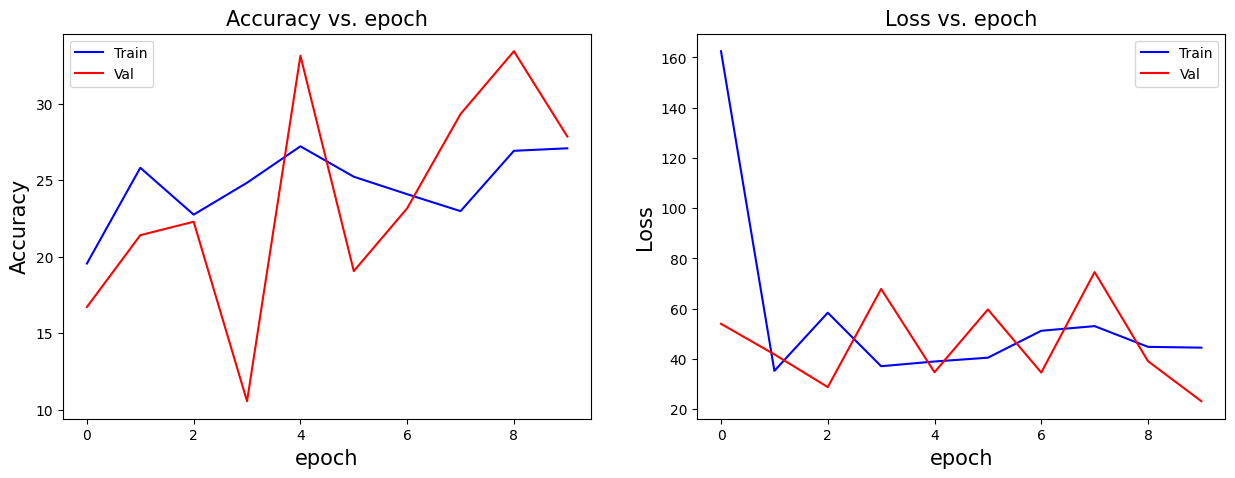

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.ravel()

#accuracy graph
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['accuracy']], label='Train', color='b')
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['val_accuracy']], label='Val', color='r')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

#loss graph
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['loss'], label='Train', color='b')
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['val_loss'], label='Val', color='r')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()

#display the graph
plt.show()

b. Let's evaluate it on Test Dataset

We will calculate accuracy and generate confustion-matrix on the Test Dataset!

In [19]:
# load model from pretrained checkpoints (optional)
# Note: Try different file extensions based on what's available
try:
	model.load_weights("Saved Models/L1_ann_model.weights.h5")
except:
	try:
		model.load_weights("Saved Models/L1_ann_model.keras")
	except:
		print("Warning: Could not load pretrained weights. Using current model weights.")

# run model prediction and obtain probabilities
y_pred = model.predict(test_ds)

# get list of predicted classes by taking argmax of the probabilities(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)

# get list of class names
class_names = test_data.class_names

# create list of all "y"s labels, by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# calculate accuracy
test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Accuracy: 31.18%



2025-06-22 15:14:12.903709: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


2025-06-22 15:14:13.027241: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


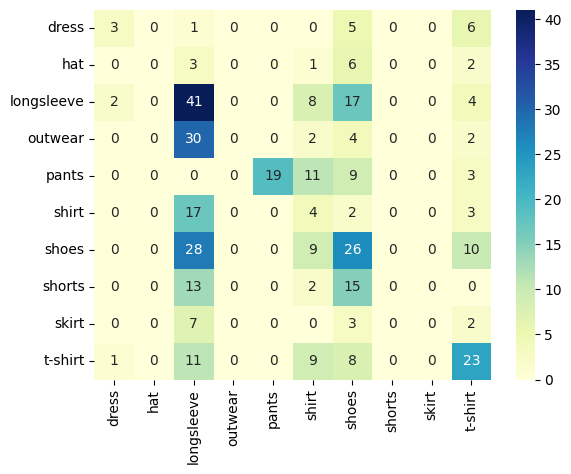

In [20]:
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    # run model prediction and obtain probabilities
    y_pred = model.predict(ds)
    # get list of predicted classes by taking argmax of the probabilities(y_pred)
    predicted_categories = tf.argmax(y_pred, axis=1)
    # create list of all "y"s labels, by iterating over test dataset
    true_categories = tf.concat([y for x, y in ds], axis=0)
    # generate confusion matrix and plot it
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

ConfusionMatrix(model, test_ds, test_data.class_names)

c. Let's also plot few samples from test set along with their predicted softmax probabilities.

- We plot the image and the predicted array (as bar plot) side-by-side.
- The predicted array is the class probabilities (output from softmax layer) corresponding to 10 classes.
- If the tallest bar (argmax) in the bar-plot is the true label, we color it blue else it's colored red.
- Height of the bar plot indicates what's the probability of it predicting that label.

In [21]:
# function to plot image given image, its true label and class probabilities (pred_array)
def plot_image(pred_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                class_names[true_label]),
                                color=color)

# function to plot barplot of class probabilities (pred_array)
def plot_value_array(pred_array, true_label):
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), pred_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(pred_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


2025-06-22 15:14:13.260151: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


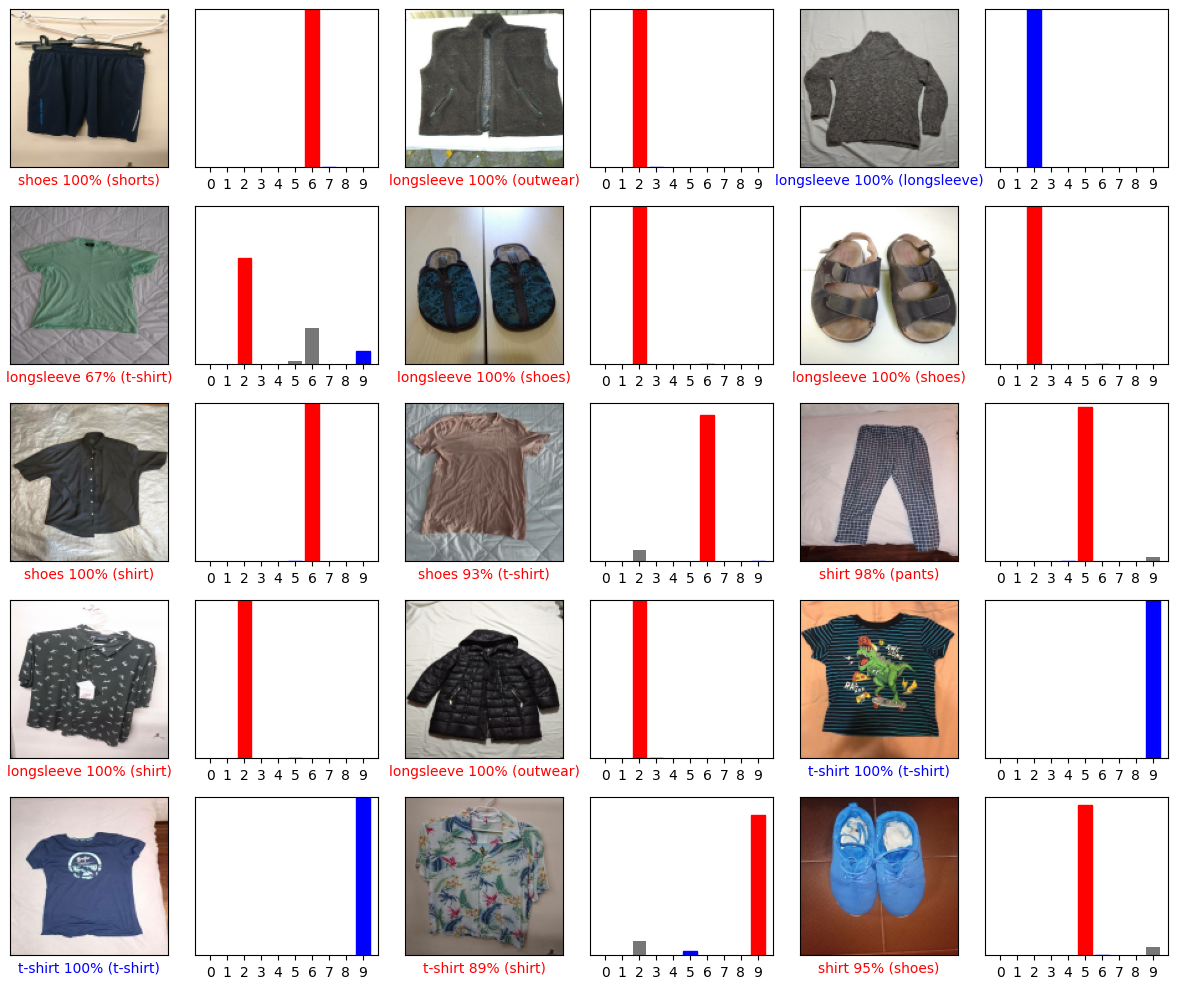

In [22]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(y_pred[index], true_categories[index], images[index])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(y_pred[index], true_categories[index])
plt.tight_layout()
plt.show()

### 3.4 Replacing Vanilla NN with CNNs  

- We saw hammering image data doesn't yield good results. Let's find the right set of tool that would do its job, aka CNNs.
- Let's replace the first dense layer with a simple convolution block, keeping everything else same.  
- A typical Convolution Block comprises of a `Conv2D` layer followed by a `MaxPooling2D` layer!    

*(Don't worry if you don't understand what all of this means, it will be explained in detail in later sections)*

a. Model Architecture  

In [23]:
num_classes = 10
hidden_size = 256

model = keras.Sequential(
    name="model_cnn",
    layers=[
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units=hidden_size, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [24]:
tf.keras.utils.plot_model(model, to_file="model_cnn.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [25]:
model.summary()

Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,780,490 (64.01 MB)

 Trainable params: 16,780,490 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

b. Compile the model with **cross-entropy** loss and **adam** optimizer:

In [26]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 3.5 Training and Evaluation with CNNs

a. Training for same 10 epochs

In [27]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1995 - loss: 18.6947 - val_accuracy: 0.2698 - val_loss: 2.1260
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3679 - loss: 1.9060 - val_accuracy: 0.4164 - val_loss: 1.8767
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5005 - loss: 1.5467 - val_accuracy: 0.4282 - val_loss: 1.7630
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5982 - loss: 1.2511 - val_accuracy: 0.4663 - val_loss: 1.7181
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6819 - loss: 1.0077 - val_accuracy: 0.5103 - val_loss: 1.6726
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7632 - loss: 0.7985 - val_accuracy: 0.5191 - val_loss: 1.7417
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8185 - loss: 0.6013 - val_accuracy: 0.5015 - val_loss: 1.8691
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8693 - loss: 0.4654 - val_accuracy: 0.5660 - 

b. How well the training go?  

Accuracy and Loss Plots on train/val datasets

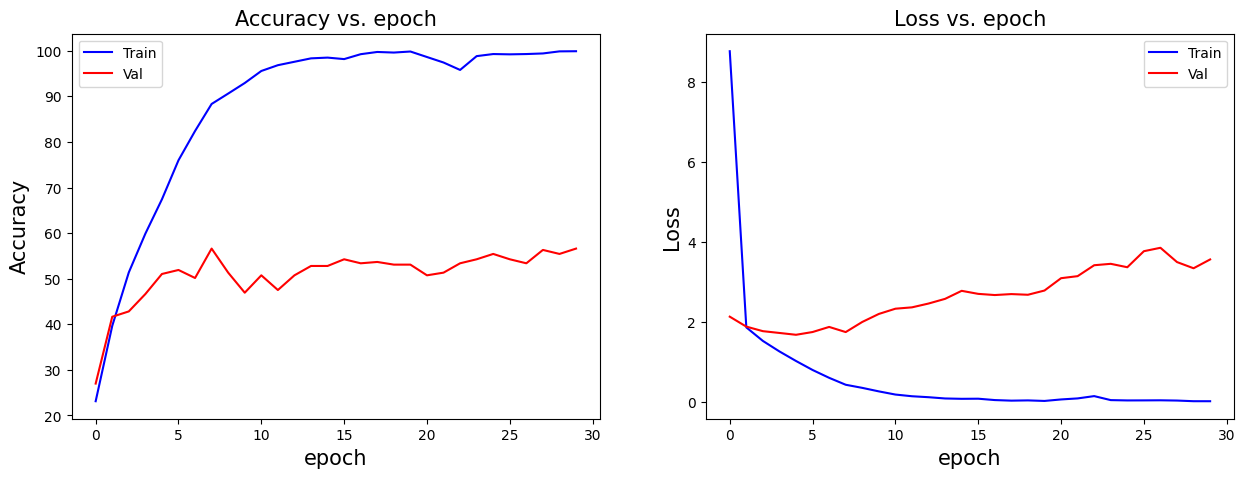

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
ax = axes.ravel()

#accuracy graph
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['accuracy']], label='Train', color='b')
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['val_accuracy']], label='Val', color='r')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

#loss graph
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['loss'], label='Train', color='b')
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['val_loss'], label='Val', color='r')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()

#display the graph
plt.show()

c. Evaluation on Test Dataset  

Print Classification Report, Confusion Matrix and plot a few samples (with their probabilities)!

In [29]:
# load model from pretrained checkpoints (optional)
#model.load_weights("/content/Saved Models/L1_cnn_model.ckpt")

true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names
predicted_categories = tf.argmax(y_pred, axis=1)

test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Test Accuracy: 46.51%



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


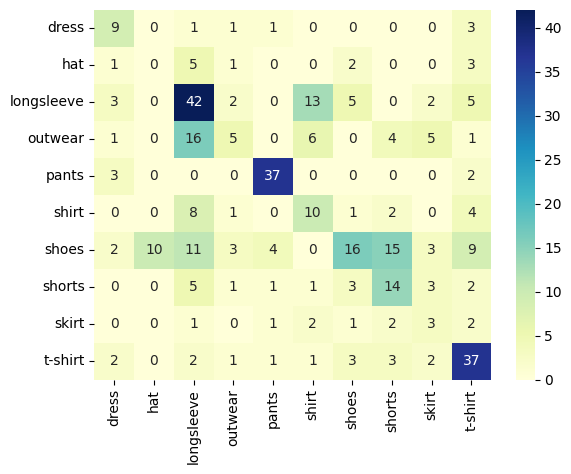

In [30]:
ConfusionMatrix(model, test_ds, test_data.class_names)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-06-22 15:15:13.915255: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


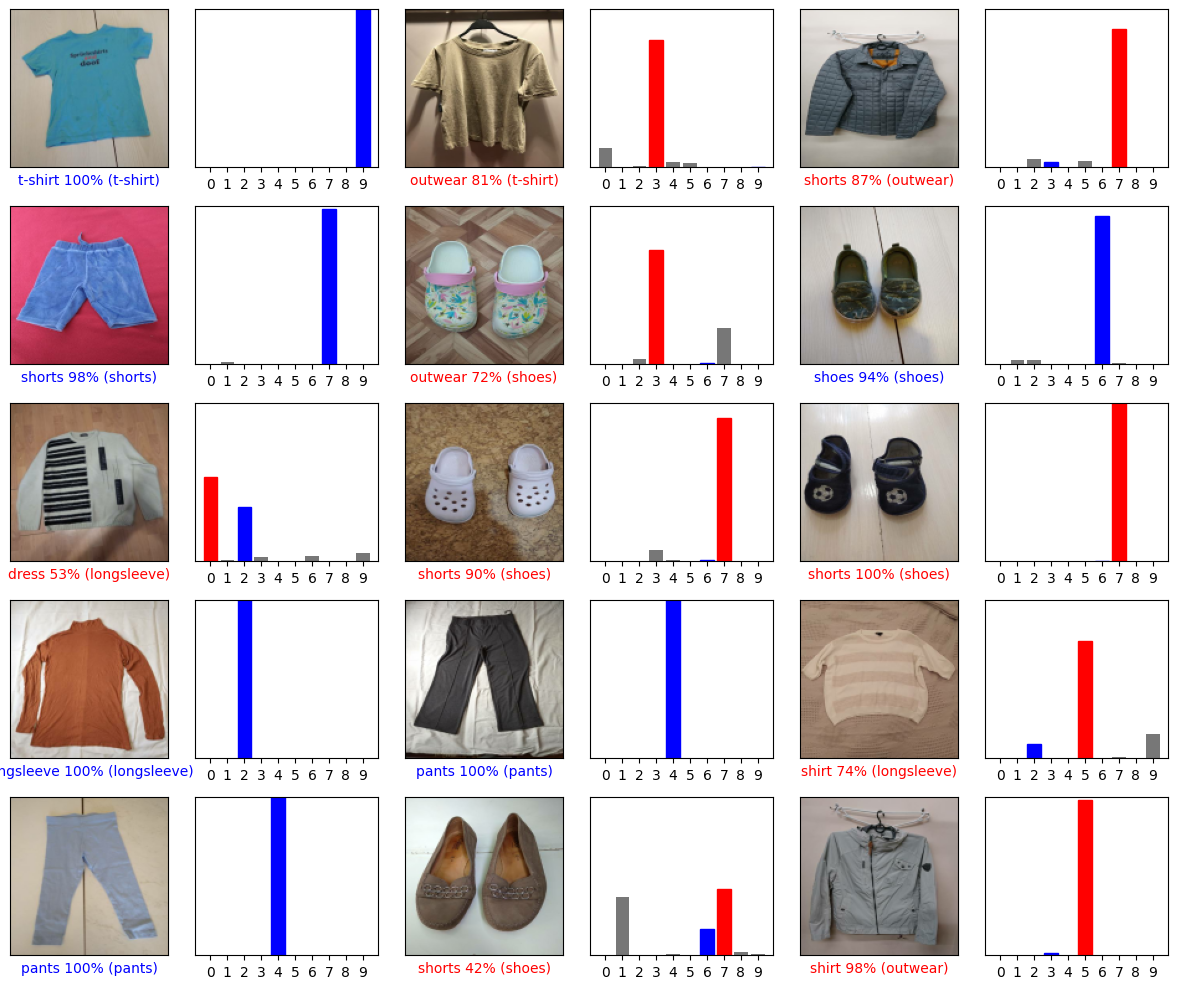

In [31]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(y_pred[index], true_categories[index], images[index])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(y_pred[index], true_categories[index])
plt.tight_layout()
plt.show()

**We see a BIG jump in accuracy numbers** both for validation and test sets. Therefore, where we have screw aka image data, using a specialist tool like screw-driver (CNNs) instead of a hammer (vanilla NN) proves to be more effective!

- In the next section we will investigate why Vanilla NN performed poorly on image data, what special properties CNN possess and how CNN architecture is different than that of Vanilla NN.

# PART 2: Understanding the Screwdriver (CNN)

Now that we tried to hammer(ANN) a Screw (Image data) i.e. fit our data to a ANN, we observed :
- ANN gave an test accuracy of 27% on the data
- By adding a single Covolutional and MaxPool layer to the existing network,
- we achieved 51% (nearly double) test accuracy

>This raises 2 IMPORTANT questions:
1.   #### **Why did the *Hammer* (MLP) FAIL in this *scenario* (Image Data)?**
2.   #### **What SPECIAL Features helped Screwdriver (CNN) to succeed?**

#### Let's address them one by one:

## 1. **What are the problems with MLP for Image Data?**

### a. MLP will **react differently to an image and its shifted version**
- Since **MLP flattens the image, it is not position invariant**
- In PART 1, we fitted our image to ANN
- Converted the image into a single feature vector,
- hence **not considering** the neighbouring pixels, and
- most importantly the Image channels (R-G-B)

Lets take an example

- Supposedly we have **two images of the same dog but at two different position**
- One on the Upper left while one on the middle right

><img src='https://drive.google.com/uc?id=1s0OD8Zdh0J7yFsvqvGeFEir5dzNCMjf_' height=200>                  <img src='https://drive.google.com/uc?id=1m_zIzbJGuXXTacENxTMeVb1dHvrpzb-E' height=200>

- Now since MLP will **flatten the matrix, the neurons which might be more active for the first image will be dormant for the second one**
- Making **MLP think these two images having completely different objects**




### b. **MLP doesnot consider Spatial relations**

- Spatial Information (like if a Person is standing at the right side of the Car or The red car is on the left side of the blue bike) gets lost when image is flattened

- Flattening also loses the internal representation of the 2D image.

### c. **Includes too many Parameters**
- Since **MLP is a fully connected model, it requires a neuron for every input pixel of the image**

- Now Lets take an example with an image of size (1280 x 720) .
  - For an image with **dimension as such the vector for the input layer becomes (921600 x 1)**. if a **Dense layer of 128 is used  then the number of parameters  equals = 921600*128.**
  - This makes **MLP infeasible  for large image** and it may **cause overfitting.**



#### Do we even require global connectivity ?
- The global connectivity  caused due to densely connected neurons leads to  more reduntant parameters which makes the MLP overfit

### With all the above discussion we need:
- to make the system translation (position) invariant
- to leverage the spatial correlation between the pixels
- focus only on the local connectivity


## **Quiz 2.** Which of the following statements is False with regards to MLP for image data as input ?
<br>
a) MLP’s don’t consider spatial relations in an image<br>
b) MLP’s usually have lesser parameters when compared to CNN’s because they are fully connected.<br>
c) CNN’s are preferred over MLP’s for image data<br>
d) None of the above<br>
<br><br>

**Ans** : b)<br>
In MLP’s,  Each node is connected to each node in the previous and the next layer, which causes it to have a very high number of parameters.



## **2. What should be the SPECIAL Features of CNN?**

From the above discussion and taking inspiration from our visual cortex system, there are 3 essential properties of image data:

**1. LOCALITY** : Correlation between neighbouring pixels in a Image  
**2. STATIONARITY** : Similar Patterns appearing multiple times in a Image  
**3. COMPOSITIONALITY** : Extracting higher level features by pooling lower level features



### **Can we add these properties to Vanilla NN? If yes, How?** [Optional]

- **Sparse Connections for Locality** - Since we already know that in the case of images, local features are highly correlated as opposed to far-away features, lets get rid of the far-away connections and make it sparse as shown below!   
This restricts the Receptive Field (RF) of the neurons from 5RF to 3RF for the next hidden layer (3RF)!
><img src='https://drive.google.com/uc?id=1z9RR-NHbJXnb2Vuxc_I0v-4XwX_vDnYB' height=320>
<img src='https://drive.google.com/uc?id=10Frr3nGMeqvEVe3kiyoKq7pXwH2nLkql' height=380>
    
    *Note that the Receptive field of the hidden layers wrt to the initial layers increases as we go deeper!*

- **Parameter Sharing for Stationarity** - Also, since there are repeating patterns in an image, it could be helpful to share some connections as shown below.
><img src='https://drive.google.com/uc?id=1Fgp7vqGusF4vNScha7dvCUe2D-tRkoz0' height=250 width=700>  


- Both these operations combined, greatly reduces the number of parameters in the architecture while preserving the "inductive bias" in the input signal. ***Note that, unlike in MLP; here, the number of parameters is now independent of number of neurons in the previous layer!***

####In 2D, these two operations lead to a set of learnable parameters of size **k*k** (called Filters or Kernels) and the computations performed by these kernels are called **CONVOLUTION**!

##Components in CNN:

### Q. What is a **Convolution Operation**?
In terms of deep learning, an (image) convolution is an element-wise multiplication of two matrices followed by a sum.
1. Take two matrices (which both have the same dimensions).
2. Multiply them, element-by-element (i.e., not the dot product, just a simple multiplication).
3. Sum the elements together.

We’ll learn more about convolutions, kernels, and how they are used inside CNNs in the remainder of this section.


#### Now we will see how this kernel will work in the case of grayscale image or 2D matrix -

### What is a 2D Kernel ?

><img src='https://drive.google.com/uc?id=1mQ95EJrwQ_5LoGGiAU-9pT29V0hiM5fg' height=350> <img src='https://drive.google.com/uc?id=1h5uJOQyvN2GQheJF9ost1uq6SBj9Lyjz' height=350>



- A kernel can be visualized as a small matrix that slides across, from left-to-right and top-to-bottom, of a larger image.
- At each pixel in the input image, the neighborhood of the image
is convolved with the kernel and the output stored.
- Inshort, a kernel find relations within the neighbouring pixels in its area iteratively and once the finishes sliding over the image, it is able to correlate certain features in a image
- For example :
    - We have an image of a car on a road, the kernel when sliding over the image wil be able to identify the edges (shape) of a car, by correlating the pixels between the car and the road.
### **Let's see how can we make Computer to detect vertical edges ?**

><img src='https://drive.google.com/uc?id=1OoNlFfmCNyky1bXHDmc4KpWoJiPCqJDY' height=250>




#### By using APPROPRIATE kernels/filters.

Let's try to apply the Sobel vertical edge filter ourselves on the image above and see the results !

In [32]:
# Downloading the image
!gdown 1TE-0GfSsWXaau_sMwO5_RgB84SSylOyk

/Users/shivam13juna/Documents/virtual_envs/appy/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TE-0GfSsWXaau_sMwO5_RgB84SSylOyk
To: /Users/shivam13juna/Documents/scaler/CV/june_2025/cycle_people.png
100%|██████████████████████████████████████| 16.2k/16.2k [00:00<00:00, 33.3MB/s]


In [33]:
# Importing necessary libraries
import cv2
from google.colab.patches import cv_imshow

# Reading the image file using OpenCV
img = cv2.imread('/content/cycle_people.png')

# Displaying the input image
cv_imshow(img)

ModuleNotFoundError: No module named 'google.colab'

Let's now use the cv2.Sobel() function to apply the Sobel vertical edge filter on the above image

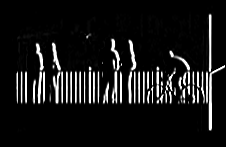

In [ ]:
# Apply the Sobel filter

# The ddpeth parameter specifies the desired depth of the output image. In this case, it is set to 64-bit floating point values.
# dx and dy parameters specify the order of derivative to be taken in the x and y directions respectively.
# kzise parameter specifies the size of the Sobel filter
output = cv2.Sobel(img, ddepth = cv2.CV_64F, dx = 1, dy = 0, ksize = 3)

# Displaying the output image
cv_imshow(output)

Let's take an example of grayscale or 2d or  1-channel Input Image and a given 3x3 kernel -
- Here **10 denotes a bright pixel while 0 denotes a dark one**
- Let's now convolve the kernel on the Image to see what we get as output:

><img src='https://drive.google.com/uc?id=1Nmco7hrrBxtSkpzCXi0Lji3uOjCerLnc' height=400>

- See how the **top element of the kernel captures brighter pixels** and the **darkest pixels can be captured by the bottom elements**

- Now we will convolve or traverse the kernel to each of the selected region **(highlighted in pink in image above)**

- **multiply each element to the kernel/filter element** and then **sum them all**

- the **value comes out to be 0** which forms the first element of the output matrix.   

- Now the **kernel then shifts one column to the right** and again computes the operation. The amount of shifting is also called `stride`. In this case the stride is 1 both in horizontal and vertical direction. If the kernel shifted by two column towards right and only one towards botton, stride would have been (2,1).

- Notice **after some computing**, the **output matrix was able to detect the horizontal line** which separated the bright and dark object.

- Also this **shifting of kernel/filter help make the image translation invariant** as **no matter where the horizontal line is**, the **output matrix will have the same pixel values for the horizontal lines.**  

####Q. **What kind of filter do you think we can use for detecting vertical edges?**
><img src='https://drive.google.com/uc?id=1lMLZjq7awxvRUbdedUoFxyIl3WmQLlMQ' height=220>


####Q. **How can we apply both horizontal and vertical edge detector on the same image matrix?**

- By stacking Output from both the filters applied separately to the image!  
- Notice that there is now a third Dimension to the Output Image, which is equal to the number of filters.

> <img src='https://drive.google.com/uc?id=1udcOi7-MLlSVq0NEY7M5ASj3qNUVC3KI' height=300 width=1000>




####Q. **What happens when we have a RGB Image as Input?**

- If the Input Image has more than 1 channel, each Kernel will have a depth associated with it (which is equal to the number of channels in Input Image) and the Convolution will be performed over the entire **VOLUME** of the input image as show here:
> <img src='https://drive.google.com/uc?id=1QeT8Ot0QCSSE0zTwFz05K0nNF4DaP6a1' height=270>


- In the case of 2 filters, we get an output dimension of 4x4x2.
> <img src='https://drive.google.com/uc?id=1_SrrE9GLYrb1660H0MSDar8eSSmLF4vh' height=300>


#### Q. **Are these two Kernels enough to know?**

- Until now, we have seen just two kernels, Horizontal and Vertical; but there can be arbitrarily many such kernels which extracts useful features from image. Which all kernels to keep depends on the type of problem and datasets, we are dealing with.   
- But in the case of Deep Learning, we don't handcraft feature extractors, rather we let the model learn them using **Gradient Descent**!  
- Similarly here too, we will just specify the dimension and number of kernels we want, and let the model learn the values in each of those kernel.
- These learnable kernels essentially form a **Conv Layer**.

#### Q. **If these Kernels are learnable, how many number of parameters are there in a Convolution Layer?**

- Number of parameters in a Conv Layer depends on the filter size, no. of filters, and the input image dimension.

- Thus for every filter, we have `(m * n * d)+1` parameters, where m,n stands for width and height of the filter and d is the number of channels in previous layer. Additional 1 bias term is also added.
- In total for `k` filters, we have `((m *n *d)+1)*k` parameters.


#### Q. **Calculate the number of parameters in the Conv Layer of the CNN architecture (Part 1)?**

- In the Conv Layer, total no. of params is just ((3 \* 3 \* 3) + 1) * 48 = 1334

###Q. Did you notice that we have always used **Odd** Kernel Size of 3x3 instead of **Even** like 2x2 or 4x4? Why?

- In Odd sized kernel, all the previous layer pixels would be Symmetric around the Output pixel
- Without this Symmetric, we will account for distortion across all the layers which happen when we use Even sized kernel.

Let's understand this with an example:
- On the left, we have a 3×3 matrix. The center of the matrix is located at
x = 1, y = 1 where the top-left corner of the matrix is used as the origin and our coordinates are zero-indexed.
- But on the right, we have a 2×2 matrix. The center of this matrix would be located at x = 0.5, y = 0.5.
- But as we know, there is no such thing as pixel location (0.5, 0.5) – our pixel coordinates must be integers! This reasoning is exactly why we use odd kernel sizes i.e. to always ensure there is a valid (x, y)-coordinate at the center of the kernel.
><img src='https://drive.google.com/uc?id=1kIUdSmmcBn4EZkiBt183KEKBXppAWG1p' height=300>
  
Thus, we use an odd kernel size to ensure there is a valid integer (x, y) coordinate at the center of the image.

####One more thing, Did you notice that the output matrix has a shape of 4x4 instead of 6x6?

###Q. **Why did the shape of the output matrix reduce ?**
- The filter/kernel was shifting and computing over 3x3 region
- So the area covered by the kernel/filter: `o = n-f+1`
  - where o is the output dimension, n is the input dimension and f is the kernel dimension  
- Hence the Output dimension of the matrix became: `6-3+1 = 4`

#### Q. **How can we solve the issues of shrinking output and less use of corner pixels?**

- By **Padding or adding pixels around the border** of the image before applying convolution.

#### Let's understand it in more detail:


### Q. Why **Padding** is required in convolution?
- By applying the convolution operation without padding, we not only get output which is smaller in shape but more importantly, we loose the information at the corner of the images.
- The following diagram show that without padding the corner pixels are covered only 1 times, edge pixel are covered 2 times and all the remaining pixels are covered 3 times.
><img src='https://drive.google.com/uc?id=1mQ95EJrwQ_5LoGGiAU-9pT29V0hiM5fg' height=350> <img src='https://drive.google.com/uc?id=1Fok3EPH7EKJ-e2lP5T45phfh_72aC8mK' height=350>

By padding we ensure that all the pixels are covered equally as shown in the figure above. [Image]
- The output shape, `o` is now given by;
    `o = n+2p-f+1`, where p is the padding width applied at all sides.

Alternative Explanation:
- If we attempted to apply convolution at the pixel located at (0,0), then our 3×3 kernel would **“hang off”** off the edge of the image.
- Notice how there are no input image pixel values for
the first row and first column of the kernel. Because of this, we always either start convolution at the first valid position
<!-- <img src='https://drive.google.com/uc?id=10wB6bAxpVCod38m_AUL61idMTp5AuW6c' height=350> -->


Thus padding is helpful because of following reasons:
  1. It help us in preserving the information at the corner of the image. Without padding, the information at the corner of the image will be lost.
  2. Without padding, the height $n_H$ and width $n_W$ decreases after the convolution operation. By using the padding, we can apply the convolution operation without decreasing the height and width of the image.

####Q. **Is there another way to reduce the dimension of layer outputs and possibly control it?**

Yes. **Through Stride Size.**

- Strides define by how much the kernel will **slide** on the Input Image while Convolving.
- Keeping a higher value of stride leads to quicker decrease in dimension of the Image. The image shown below shows stride of 2.

> <img src='https://drive.google.com/uc?id=1mNgr-edMr3xu4DmFwJ5rZ410QW0rfxPm' height=300>

- The new output shape, `o` is now equal to; `o = (n+2p-f)/s + 1`.  

###Thus the formula for output shape is given by:
> <img src='https://drive.google.com/uc?id=1uHepupWMJIHxTQ9PEIJ6TLu0Mc7VItvG' height=70>


#### Q. **What is the effect of using a larger stride?**

  - Lesser Memory needed for output
  - The Output Spatial dimensions are smaller which when simplify the model
  - It avoids Overfitting by not overlapping redundant pixels together

### **Lets now revisit the code where we used Convolution layer and understand its arguments** -

In [ ]:
layers.Conv2D(filters=48, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(128, 128, 3))

Let's go over the arguments, one by one:
1. `filters`: It denotes number of unique filters that this convolutional layers will learn. This also determines the number of output filters in the convolution.
2. `kernel_size`: This specifies the size of the kernel/filter which will convolve over the previous layer. It can be either an integer value or a 2-tuple denoting the width and height of the 2D convolution window, like `(3,3)`, `(5,5)` etc.
3. `strides`: Like kernel_size, we can specify the distance by which the kernel would slide over the input image in terms of integers or a tuple of 2 integers. Default is `(1,1)`.
4. `padding`: As discussed, padding can be of two types, `same` or `valid`. Same keeps the output spatial dimensions same as the input, whereas valid means no padding, and allows the size to shrink as a result of convolution. Defaults to `valid`.
5. `activation`: Added for convenience, this argument specifies what type of non-linearity should be applied *after convolution*! Defaults to `None`.
6. `input_shape`: Need to be provided only if it is the first layer in the network! The input shape helps to determine the number of parameters in the layer and the output shape!

## **Quiz 3:** Which of the following are True about Padding in CNN?<br><bR>
a) We should use valid padding if we know that information at edges is not that much useful.<br>
b) We compromise to lose some edge information of the image in the case of ‘same’ padding.<br>
c) There is no reduction in dimension when we use ‘same’ padding.<br>
d) In ’valid’ padding, we drop the part of the image where the filter does not fit.
<br><br><br>Ans : a), c), d)
<Br>
**Solution :** <br>
- We use valid padding if we know that information at edges is not that much useful.(The output size of the convolutional layer shrinks depending on the input size & kernel size.)
- In zero padding, we pad zeros around the border of the image to save most of the information, whereas in valid padding, we lose out on the information which doesn’t fit in filters.
- There is no reduction in dimension when we use zero padding.(This is True)
- In valid padding, we drop the part of the image where the filter does not fit. (This is True)
<br><br>
Hence, A, C and D are correct.


## **Pooling**
   Apart from Conv2D, we also used another specific module called `MaxPooling2D` in our model, which had no learnable parameters.  

#### Let's try to understand what is Pooling and what is the significance of a Pooling Module.  

   The pooling layer helps in reducing the height and width of the image. Thus, it helps in reducing the number of parameters and also make invariant to the position in the input. In other words, it induces "compositionality" in our model architecture.

   There are two kinds of pooling :   

   1. Max pooling : The filter of size $(f,f)$ is slided over the input with a stride and we take the maximum in that region. It is used in between the Conv Layers.
   
   2. Average pooling : The filter of size $(f,f)$ is slided over the input with a sride and we take the average in that region. This type of pooling is generally used just before the Fully connected layers for feature extraction!


><img src='https://drive.google.com/uc?id=1inJMPLbFxf5MyLRIOYHIjhIqEw_r31Ho' height=270> <img src='https://drive.google.com/uc?id=1TFIRlEtBxAjXqg-tFzj9hgXoWuEQb2Lc' height=270>


  The above figure illustrates the max pooling and average pooling using a filter (2,2) dimension and having a stride of 2.



#### Q. **Does pooling layers add any learnable weights to the network?**
- **No, since notice that no kernel/filter matrix is considered.**
- Hence no parameters are needed while computing pooling

#### Q. **What is the Output shape after pooling layer?**
The output shape is given by: $o = floor[(\frac{n-f}{s}) + 1]$, where n is the input size, f is the pooling filter size and s is the stride size.


### Let's now see How Pooling works in Keras?

In [ ]:
layers.MaxPooling2D()

In [ ]:
layers.AveragePooling2D(),

(<keras.layers.pooling.AveragePooling2D at 0x7f13fdaaca50>,)

Both these Pooling layers have 2 important arguments:

1. `pool_size`: This is the size of the window on which pooling will be applied. By default this size is 2. Can be an integer or a tuple of 2 integers. It can also be thought of as a non-learnable filter which either calculates max over the region or average out the values.
2. `strides`: This is same as the one in `Conv2D` layer. Default is None, which means that the stride size is same as the pool size.

### Why we do flattening in CNN ?
- This step is pretty simple, lets have a short discussion

- After finishing the previous two steps, we're supposed to have a pooled feature map by now.
- As the name of this step implies, we are literally going to flatten our pooled feature map into a column like in the image below.

> <img src='https://drive.google.com/uc?id=1aIWkfcjMaEnj7hOYPSjlBoS4Pb0000Qf' height=260 width=620>



The reason we do this is that we're going to need to insert this data into an artificial neural network later on.

><img src='https://drive.google.com/uc?id=17D_z-xzRSCJZK5OMsaVEJycMWnrTk2dV' height=270>


As you see in the image above, we have multiple pooled feature maps from the previous step.

What happens after the flattening step is that you end up with a long vector of input data that you then pass through the artificial neural network to have it processed further.




## **Quiz 4.** An input image has a matrix of size 12 X 12. A filter of size 3 X 3 with a Stride of 1 and no padding is applied on this image input. <br>Determine the size of the output matrix.

a) 10 X 10<br>
b) 12 x 12<br>
c) 9 x 9<br>
d) 10 x 12<br>
<br>

**Solution :** Use the formula : C = ((n-f+2p)/s)+1<br>
Here, n = 12<br>
F = 3<br>
P = 0<br>
S = 1<br>
C = ((12-3+0)/1) + 1<br>

Output size = 10 x 10


## Summary :

To sum up, here is what we have after we're done with each of the steps in our first CNN that we have covered up until now:

- Input image (starting point)
- Convolutional layer (convolution operation)
- Activation function
- Pooling layer (pooling)
- Input layer for the artificial neural network (flattening)
- Dense layer
- Loss function

In the next class, we will discuss more about the CNN components  and how to deal with overfitting in CNN.